Bienvenido al optimizador de portafolios de Markowitz.
Por favor, cargue su archivo de datos en formato .csv. Debe tener:
- La primera columna con las fechas o años.
- Las columnas siguientes con los precios históricos de los activos.


Ingrese la ruta del archivo .csv:  Data2 (1).csv


Archivo cargado correctamente. Columnas detectadas: ['AÃ±o', 'S&P', 'Nasdaq', 'Bonos', 'Mercado Monetario']
Estadísticos calculados con éxito.
Media geométrica (μ):
S&P                  0.103748
Nasdaq               0.108774
Bonos                0.072724
Mercado Monetario    0.045043
dtype: float64

Matriz de covarianza (Σ):
                        S&P    Nasdaq     Bonos  Mercado Monetario
S&P                0.002936  0.001479 -0.000177           0.000198
Nasdaq             0.001479  0.006392 -0.000444           0.000429
Bonos             -0.000177 -0.000444  0.003468           0.000040
Mercado Monetario  0.000198  0.000429  0.000040           0.000108

Valores propios de la matriz de covarianza: [7.03431970e-03 7.38090535e-05 2.39020171e-03 3.40628591e-03]
La matriz de covarianza es positiva semidefinida (PSD). El problema es convexo.


Ingrese el valor de R_min (rendimiento esperado mínimo, en decimal):  0.065
Ingrese el valor de R_max (rendimiento esperado máximo, en decimal):  0.105


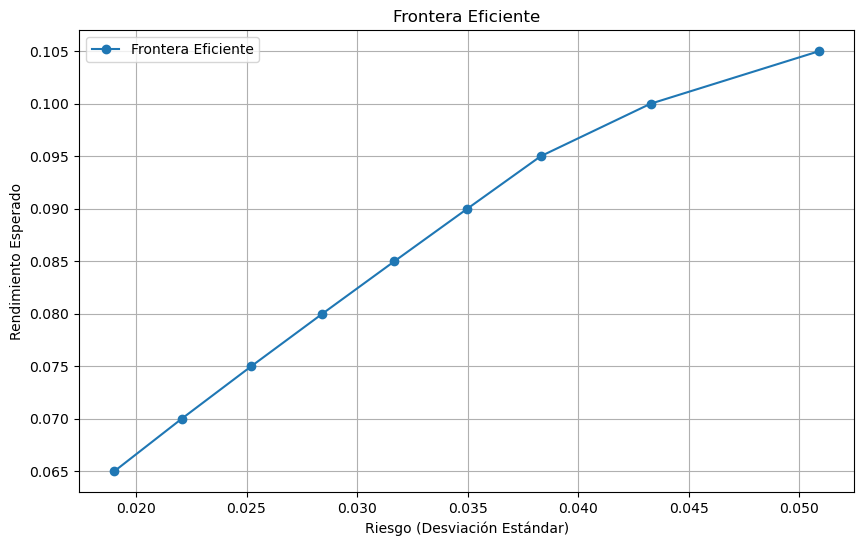

Optimización completada. Portafolios generados:

Portafolio 1:
- Rendimiento esperado: 0.0650
- Riesgo (desviación estándar): 0.0190
- Pesos: {'S&P': 0.21403197283757763, 'Nasdaq': 0.05488215811769369, 'Bonos': 0.14069361041658243, 'Mercado Monetario': 0.5903922586281463}

Portafolio 2:
- Rendimiento esperado: 0.0700
- Riesgo (desviación estándar): 0.0221
- Pesos: {'S&P': 0.2614135153033265, 'Nasdaq': 0.07749636014360338, 'Bonos': 0.168771714487268, 'Mercado Monetario': 0.4923184100658021}

Portafolio 3:
- Rendimiento esperado: 0.0750
- Riesgo (desviación estándar): 0.0252
- Pesos: {'S&P': 0.3087950577690755, 'Nasdaq': 0.10011056216951325, 'Bonos': 0.19684981855795372, 'Mercado Monetario': 0.39424456150345755}

Portafolio 4:
- Rendimiento esperado: 0.0800
- Riesgo (desviación estándar): 0.0284
- Pesos: {'S&P': 0.3561766002348242, 'Nasdaq': 0.12272476419542297, 'Bonos': 0.22492792262863925, 'Mercado Monetario': 0.29617071294111363}

Portafolio 5:
- Rendimiento esperado: 0.0850
- Riesgo 

In [11]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def calculate_returns(data):
    """Calcula los rendimientos porcentuales."""
    returns = data.iloc[:, 1:].pct_change().dropna()  # Excluir la columna de "Año"
    return returns

def calculate_geometric_mean(returns):
    """Calcula la media geométrica de los rendimientos."""
    return (np.prod(1 + returns, axis=0)**(1 / len(returns))) - 1

def calculate_covariance_matrix(returns):
    """Calcula la matriz de covarianza."""
    return returns.cov()

def optimize_portfolio(mu, sigma, r_min, r_max, step=0.005):
    """Optimiza el portafolio para un rango de rendimientos esperados."""
    n = len(mu)
    x = cp.Variable(n)  # Pesos del portafolio
    risk = cp.quad_form(x, sigma)  # Riesgo cuadrático (minimizar)
    returns = mu.values @ x  # Rendimiento esperado
    
    constraints = [
        cp.sum(x) == 1,  # Todos los fondos están invertidos
        x >= 0           # Pesos no negativos
    ]

    results = {
        "target_return": [],
        "risk": [],
        "weights": []
    }

    for r_target in np.arange(r_min, r_max + step, step):
        constraints_with_return = constraints + [returns >= r_target]
        problem = cp.Problem(cp.Minimize(risk), constraints_with_return)
        problem.solve()

        if problem.status == cp.OPTIMAL:
            results["target_return"].append(r_target)
            results["risk"].append(np.sqrt(risk.value))  # Desviación estándar
            results["weights"].append(x.value)
    
    return results

def plot_efficient_frontier(results, title):
    """Genera un gráfico de la frontera eficiente."""
    plt.figure(figsize=(10, 6))
    plt.plot(results["risk"], results["target_return"], marker='o', label='Frontera Eficiente')
    plt.xlabel('Riesgo (Desviación Estándar)')
    plt.ylabel('Rendimiento Esperado')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

# Interfaz con el usuario
print("Bienvenido al optimizador de portafolios de Markowitz.")
print("Por favor, cargue su archivo de datos en formato .csv. Debe tener:")
print("- La primera columna con las fechas o años.")
print("- Las columnas siguientes con los precios históricos de los activos.")
file_path = input("Ingrese la ruta del archivo .csv: ")

try:
    data = pd.read_csv(file_path)
    print(f"Archivo cargado correctamente. Columnas detectadas: {data.columns.tolist()}")

    # Calcula rendimientos y estadísticos
    returns = calculate_returns(data)
    mu = calculate_geometric_mean(returns)
    sigma = calculate_covariance_matrix(returns)

    print("Estadísticos calculados con éxito.")
    print(f"Media geométrica (\u03BC):\n{mu}\n")
    print(f"Matriz de covarianza (\u03A3):\n{sigma}\n")

    # Verifica si la matriz de covarianza es positiva semidefinida (PSD)
    eigenvalues = np.linalg.eigvals(sigma)  # Calcular los valores propios de la matriz de covarianza
    print("Valores propios de la matriz de covarianza:", eigenvalues)

    if np.all(eigenvalues >= 0):
        print("La matriz de covarianza es positiva semidefinida (PSD). El problema es convexo.")
    else:
        print("La matriz de covarianza NO es positiva semidefinida. El problema no es convexo.")


    # Pide valores de Rmin y Rmax
    r_min = float(input("Ingrese el valor de R_min (rendimiento esperado mínimo, en decimal): "))
    r_max = float(input("Ingrese el valor de R_max (rendimiento esperado máximo, en decimal): "))

    # Optimiza portafolios
    results = optimize_portfolio(mu, sigma, r_min, r_max)
    plot_efficient_frontier(results, "Frontera Eficiente")

    # Muestra resultados
    print("Optimización completada. Portafolios generados:")
    for i, (r, risk, weights) in enumerate(zip(results["target_return"], results["risk"], results["weights"])):
        print(f"\nPortafolio {i + 1}:")
        print(f"- Rendimiento esperado: {r:.4f}")
        print(f"- Riesgo (desviación estándar): {risk:.4f}")
        print(f"- Pesos: {dict(zip(data.columns[1:], weights))}")
except Exception as e:
    print(f"Se produjo un error: {e}")
